# Open Street Maps Data Import and Analysis

## Intro

Data for Raleigh, North Carolina was downloaded from MapZen (https://mapzen.com/data/metro-extracts).

It was converted to JSON while being structured and corrected/normalized, then imported into mongodb.  Code for this processing is detailed in "02 - Code used for Data Wrangling and Exploration".

In [1]:
import re
from pymongo import MongoClient
client = MongoClient()
db = client.osm
collection = db.raleigh

## Problems encountered

There are certainly multiple problems or areas for improvement, but three issues that stuck out were:

1. Inconsistent Street Names
2. Questionable Validity of Education Ammenity Tags
3. Non-standardized Postal Codes

### Street Names

Aside from the expected standardization (such as "st" to "Street") that was required, some nodes had street names that were easily correctible but very specific.  This means they required manual checking (for example, consistency with Google Maps) and specific one-off corrections:

* "Meadowmont Village CIrcle" becomes "Meadowmont Village Circle"
* "LaurelcherryStreet" becomes "Laurel Cherry Street"
* "Garrett Driver" becomes "Garrett Drive"

Others had street names that could not be verified:

* "Triangle Family Practice"
*  Multiple similar names with no best choice:
    * "NC Highway 55 West"
    * "NC Highway 55"
    * "Highway West"
    * "Highway 55 West"
    * "Highway 55"
    * "US 55"


### Use of Amenity Tags for Education

After importing the data I took a look at a few of the "education" amenity tags ('university', 'college', and 'school') to see how the major colleges and universities in the area may be marked.

In [2]:
#Example Code: List of 'university' tags
pipeline = [
    {'$match':{'amenity':'university'}},
    {'$group':{'_id':'$name', 'count':{'$sum':1}}},
    {'$sort':{'count':-1}},
]
docs = collection.aggregate(pipeline)
for r in docs['result']:
    print(r)

{'count': 3, '_id': 'Duke University East Campus'}
{'count': 1, '_id': 'Duke University Medical Center'}
{'count': 1, '_id': 'Campbell University: Norman Adrian Wiggins School of Law'}
{'count': 1, '_id': "St. Augustine's University"}
{'count': 1, '_id': 'Duke University Central Campus'}
{'count': 1, '_id': 'JC Raulston Arboretum at NC State University'}
{'count': 1, '_id': 'North Carolina Central University'}
{'count': 1, '_id': 'Duke University West Campus'}
{'count': 1, '_id': 'North Carolina State University (Centennial Campus)'}
{'count': 1, '_id': None}
{'count': 1, '_id': 'William Peace University'}
{'count': 1, '_id': 'Campbell University RTP Campus'}


These tags seem to be infrequently used (when a name is included) and are inconsistent when they are used.  According to the specificaitons (https://wiki.openstreetmap.org/wiki/Map_Features#Education):

* "university" indicates a university campus.
* "college" indicates a college campus or building
* "school" indicates a school and grounds.

While some tags are as expected ("Duke University East Campus" appears multiple times as "university"), there are issues.

* There is no name for 1 universitiy, 28 college, and 21 school entries.
* "Durham Tech Community College" appears as a "college" while "Durham Technical Community College" appears twice as a school.
* "Duke University" is listed as a "school" while various campus regions are listed as "university".

I believe that this inconsistency is at least partially to blame on the unclear documentation for these tags.

### Non-standardized Postal Codes

Most postal codes (6,564) were valid, but there were two main groups- 5-digit and 9-digit codes.  These were standardized to 5-digit codes.  Invalid codes (there were only 6) were removed.  Regular expressions were used to identify the kind of postal code and correct it as needed:

In [3]:
postcode_re = re.compile(r'^[0-9]{5}$')
extended_postcode_re = re.compile(r'^[0-9]{5}-[0-9]{4}$')

def correct_postcode(postcode):
    """Try to convert postcode to 5 digit int"""
    if extended_postcode_re.match(postcode): #strip extended postcode with "-####"
        postcode = postcode[0:5]
        return int(postcode)
    elif postcode_re.match(postcode): #normal 5 digit postcode
        return int(postcode)
    else:
        return None
    
#Examples:
print(correct_postcode('27713'))
print(correct_postcode('27603-1407'))
print(correct_postcode('2612-6401'))

27713
27603
None


## Overview of the Data

###Filesizes:

* XML: 486.2 MiB
* JSON: 562.6 MiB

###Summary info about imported data

In [4]:
total = collection.find().count()
total_nodes = collection.find({"type":"node"}).count()
total_ways = collection.find({"type":"way"}).count()

print("{:,} Total Records".format(total))
print("{:,} Nodes".format(total_nodes))
print("{:,} Ways".format(total_ways))

2,735,730 Total Records
2,524,259 Nodes
211,464 Ways


###Total Users and Top Users (by number of records)

In [5]:
pipeline = [
    {'$group':{'_id':'$created.user', 'count':{'$sum':1}}},
    {'$sort':{'count':-1}},
]
users = collection.aggregate(pipeline)['result']

print('Total Users: {:,}'.format(len(users)))
print('Top Users by number of records:')
for u in users[0:5]:
    print(u)

Total Users: 696
Top Users by number of records:
{'count': 2139329, '_id': 'jumbanho'}
{'count': 128144, '_id': 'woodpeck_fixbot'}
{'count': 67765, '_id': 'yotann'}
{'count': 63378, '_id': 'JMDeMai'}
{'count': 43244, '_id': 'runbananas'}


### Changesets
Changesets are groups of changes made by a single user over a short period of time.

In [6]:
pipeline = [
    {'$group':{'_id':{'changeset':'$created.changeset', 'user':'$created.user'}, 'count':{'$sum':1}}},
    {'$sort':{'count':-1}},
    {'$limit':5}
]
changesets = collection.aggregate(pipeline)['result']

print('Largest 5 changesets:')
for cs in changesets:
    print(cs)

Largest 5 changesets:
{'count': 20133, '_id': {'changeset': '2453134', 'user': 'woodpeck_fixbot'}}
{'count': 19980, '_id': {'changeset': '3553745', 'user': 'jumbanho'}}
{'count': 19861, '_id': {'changeset': '3557826', 'user': 'jumbanho'}}
{'count': 19860, '_id': {'changeset': '3558134', 'user': 'jumbanho'}}
{'count': 19849, '_id': {'changeset': '3553606', 'user': 'jumbanho'}}


###Type of Fuel used for BBQ

In [7]:
pipeline = [
    {'$match':{'amenity':'bbq'}},
    {'$group':{'_id':'$fuel', 'count':{'$sum':1}}},
    {'$sort':{'count':-1}},
    {'$skip':1} #'None' - no fuel tag- are listed first because they are most common.  Skip keeping them.
]

docs = collection.aggregate(pipeline)
for r in docs['result']:
    print(r)

{'count': 4, '_id': 'charcoal'}
{'count': 1, '_id': 'gas'}


## Additional Ideas

### GNIS and TIGER Data
Some data was imported into OSM from GNIS (USGS Geographic Names Information System) and TIGER (Topologically Integrated Geographic Encoding and Referencing system).  This additional information may be useful for testing consistency. However, this data may be outdated and is a small fraction of the data overall:

In [8]:
#nodes with gnis
nodes_with = collection.find({'gnis':{'$exists':True}}).count()
nodes_without = collection.find({'gnis':{'$exists':False}}).count()
print("Fraction of Nodes with GNIS Data = {:.2%}".format(nodes_with/(nodes_with+nodes_without)))

#ways with tiger
ways_with = collection.find({'tiger':{'$exists':True}}).count()
ways_without = collection.find({'tiger':{'$exists':False}}).count()
print("Fraction of Ways with TIGER Data = {:.2%}".format(ways_with/(ways_with+ways_without)))

Fraction of Nodes with GNIS Data = 0.03%
Fraction of Ways with TIGER Data = 0.65%


In [9]:
#Number of Node references in ways with TIGER data
pipeline = [{'$match':{'tiger':{'$exists':True}}},
            {'$project':{'nodenum':{'$size':'$node_refs'}}},
            {'$group':{'_id':'', 'sum':{'$sum':'$nodenum'}}}
           ]
docs = collection.aggregate(pipeline)
tiger_noderefs = docs['result'][0]['sum']

print('{:,} total nodes ({:.2%}) are referenced by ways that have TIGER data.'.format(
        tiger_noderefs, tiger_noderefs/total_nodes))
print('However, this number may include duplicate references.')

232,715 total nodes (9.22%) are referenced by ways that have TIGER data.
However, this number may include duplicate references.


It would be relatively straightforward to add or compare this information.  For example:

1. Examine a way with TIGER data.
2. Examine the nodes referenced by the way.
3. Compare existing data in the nodes or add new data.

Here we see that several nodes are associated with a Way that has a street name, but none of the nodes have address data.  This could be added, but rules would have to be created to decided on what TIGER data is suitable for adding to nodes.

In [10]:
pipeline = [{'$match':{'tiger':{'$exists':True},'highway':'residential'}},
            {'$limit':1}
           ]
tiger_example = collection.aggregate(pipeline)['result']
print('TIGER Info:')
for k,v in tiger_example[0]['tiger'].items():
    print(k,'\t=\t', v)

pipeline = [{'$match':{'id':{'$in':tiger_example[0]['node_refs']}}},
            {'$limit':3}
           ]
matched_nodes = collection.aggregate(pipeline)['result'] 
    
print('\nReferenced Nodes:')
for mn in matched_nodes:
    print(mn)

TIGER Info:
cfcc 	=	 A41
zip_right 	=	 27523
county 	=	 Chatham, NC
name_base 	=	 Shady Lane
reviewed 	=	 no
name_type 	=	 Cir
zip_left 	=	 27523

Referenced Nodes:
{'pos': [35.7931, -78.969461], 'id': '169874357', '_id': ObjectId('559dec3c943bb0b0cde42019'), 'created': {'user': 'woodpeck_fixbot', 'timestamp': '2009-12-12T12:04:37Z', 'changeset': '3355194', 'uid': '147510', 'version': '2'}, 'type': 'node'}
{'pos': [35.793158, -78.969196], 'id': '169874359', '_id': ObjectId('559dec3c943bb0b0cde4201d'), 'created': {'user': 'woodpeck_fixbot', 'timestamp': '2009-09-11T05:08:38Z', 'changeset': '2442625', 'version': '2', 'uid': '147510'}, 'type': 'node'}
{'pos': [35.793177, -78.969106], 'id': '169874362', '_id': ObjectId('559dec3c943bb0b0cde4201e'), 'created': {'changeset': '2442625', 'timestamp': '2009-09-11T05:08:39Z', 'user': 'woodpeck_fixbot', 'version': '2', 'uid': '147510'}, 'type': 'node'}


### Possible Duplicate Nodes

A related issue is that many nodes are nearly identical- they differ only in the created timestamp, id, and ObjectId.  These seem to have been imported using automated methods since the user and changeset is the same for the duplicate records and the timestamp is either the same or very close (within 5 minutes).  This could be an intentional design feature- the nodes may have been created only to serve as points in various ways or relations. 

These could be merged in order to reduce the size of the database without losing meaninful information.  However, this compression comes at a cost- future updates that add, edit, or remove information would have to be cross-referenced with other data in order to check for conflicts.

In [11]:
#How many nodes match at least one other node's position
pipeline = [
    {'$group':{'_id':'$pos', 'count':{'$sum':1}}},
    {'$match':{'count':{'$gt':1}}}
]
docs = collection.aggregate(pipeline, allowDiskUse=True)['result']

print("{:,} nodes do not have a unique position.".format(len(docs)))

3,094 nodes do not have a unique position.


In [12]:
#How many match within a single changeset
pipeline = [
    {'$group':{'_id':{'pos':'$pos','changeset':'$created.changeset'}, 'count':{'$sum':1}}},
    {'$match':{'count':{'$gt':1}}}
]
docs = collection.aggregate(pipeline, allowDiskUse=True)['result']

print("{:,} nodes do not have a unique position/changeset combo.".format(len(docs)))

5,982 nodes do not have a unique position/changeset combo.


In [13]:
#Look at one set of these as an example
pipeline = [
    {'$group':{'_id':{'pos':'$pos','changeset':'$created.changeset'}, 'count':{'$sum':1}}},
    {'$match':{'_id.pos':{'$exists':True}}},
    {'$sort':{'count':-1}},
    {'$limit':1}
]
docs = collection.aggregate(pipeline, allowDiskUse=True)

for r in docs['result']:
    pos = r['_id']['pos']
    print("-"*30,"\n",pos,"\n","-"*30,"\n")
    overlaps = collection.aggregate({'$match':{'pos':pos}})
    for o in overlaps['result']:
        print(o)

------------------------------ 
 [35.7877479, -78.8708045] 
 ------------------------------ 

{'pos': [35.7877479, -78.8708045], 'id': '195496249', '_id': ObjectId('559dec3e943bb0b0cde5ec4d'), 'created': {'changeset': '18183244', 'timestamp': '2013-10-04T18:14:14Z', 'user': 'KristenK', 'version': '7', 'uid': '1494110'}, 'type': 'node'}
{'pos': [35.7877479, -78.8708045], 'id': '2482640856', '_id': ObjectId('559dec6e943bb0b0cd08fd47'), 'created': {'user': 'KristenK', 'timestamp': '2013-10-04T18:13:55Z', 'changeset': '18183244', 'version': '1', 'uid': '1494110'}, 'type': 'node'}
{'pos': [35.7877479, -78.8708045], 'id': '2482640858', '_id': ObjectId('559dec6e943bb0b0cd08fd48'), 'created': {'user': 'KristenK', 'timestamp': '2013-10-04T18:13:55Z', 'changeset': '18183244', 'version': '1', 'uid': '1494110'}, 'type': 'node'}
{'pos': [35.7877479, -78.8708045], 'id': '2482640859', '_id': ObjectId('559dec6e943bb0b0cd08fd4a'), 'created': {'changeset': '18183244', 'timestamp': '2013-10-04T18:13:55Z'

### Change in Dataset Over Time
It is instructive to observe changes in the size of the database over time- is the number of contributions increasing or decreasing?  Using the timestamp value it is possible to count the number of nodes or ways added over time- I examined monthly additions.  It looks like a large portion of the data was added in one month (January 2010) while other big months for 'Ways' were mostly in 2013 and big months for 'Nodes' were mostly in 2009.  This is probably due to large automated imports at those times.

In [14]:
#Group by first 7 characters of created timestamp
from collections import Counter
def get_monthly_count(collection, doctype):
    """Return the monthly count as a dict based on start of timestamp"""
    pipeline = [
        {'$match':{'type':doctype}},
        {'$group':{'_id':{'$substr':['$created.timestamp',0,7]}, 'count':{'$sum':1}}},
        {'$sort':{'count':-1}}
        ]
    counts = collection.aggregate(pipeline)['result']
    count_dict = Counter()
    for d in counts:
        count_dict[d['_id']] = d['count']
    return count_dict

node_counts = get_monthly_count(collection, 'node')
way_counts = get_monthly_count(collection, 'way')

print('\nMonths with the most Nodes:\n','-'*30)
for m in node_counts.most_common(5):
    print("{} with {:,} Nodes".format(m[0],m[1]))
    
print('\nMonths with the most Ways:\n','-'*30)
for m in way_counts.most_common(5):
    print("{} with {:,} Ways".format(m[0],m[1]))


Months with the most Nodes:
 ------------------------------
2010-01 with 1,267,448 Nodes
2009-11 with 271,430 Nodes
2009-07 with 144,939 Nodes
2009-08 with 135,390 Nodes
2009-09 with 46,642 Nodes

Months with the most Ways:
 ------------------------------
2010-01 with 89,284 Ways
2013-02 with 20,061 Ways
2013-01 with 7,724 Ways
2009-11 with 7,109 Ways
2013-04 with 5,135 Ways


The average number of additions to the database each month seem to be on a slow decline (although it still adds thousands of datapoints each month)- it's unlikely that large external databases need to be imported anymore.  I believe the database is fairly complete as far as raw positional data goes- it would be more helpful to correct and especially annotate the existing data instead of adding more.

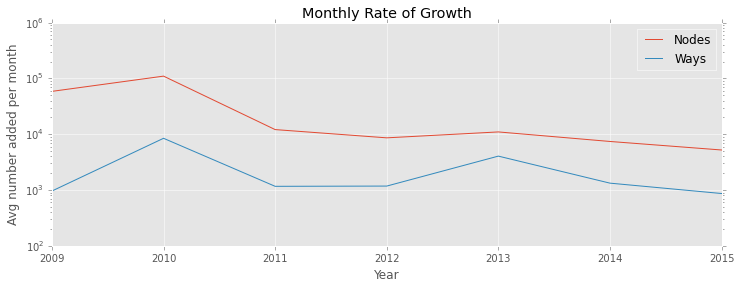

In [16]:
def avg_monthly(counts, year):
    """Calculate monthly counts"""
    counts_year = {k:v for k,v in counts.items() if k[0:4]==year}
    if len(counts_year)==0:
        return 0
    return int(sum(counts_year.values())/len(counts_year))

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

years = ['2009','2010','2011','2012','2013','2014','2015']
nodes = [avg_monthly(node_counts, year) for year in years]
ways = [avg_monthly(way_counts, year) for year in years]

fig,ax = plt.subplots(1, figsize=(12,4))
ax.plot(years, nodes, label='Nodes')
ax.plot(years, ways, label='Ways')
ax.set_yscale('log')
plt.legend(loc='best')
ax.set_ylabel('Avg number added per month')
ax.set_xlabel('Year')
ax.set_title('Monthly Rate of Growth')
ax.set_xticklabels(years)

# Conclusion

Overall the data seems to be mostly valid and uniform, but there is room for improvement.  The size of the dataset could certainly be reduced by removing redundant information like duplicate nodes (same position no differing tags), but this is a design decision balancing between complexity and compactness.  The dataset shouldn't be considered anywhere near complete when it comes to annotations that aren't standard.  For example, most nodes described as a BBQ restaurant ('amenity' of 'bbq') do not list the type of fuel used.